In [1]:
import os
import numpy as np

from refl1d.names import *
from bumps.fitters import fit

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

In [2]:
# Data directories
steady_state_data_dir = os.path.expanduser('~/Downloads')
kinetics_dir = os.path.expanduser('~/Downloads/kinetics')
output_dir = '../data'

# This is where the code is
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)

# Load the data
This should be the same data as for training

In [233]:
t = 0
delta_t = 10 # seconds
timestamps = []
data_list = []

file_list = sorted(os.listdir(kinetics_dir))[:400]
idx_list = list(range(10))
idx_list.extend(range(10, 400, 5))

for i in idx_list:

    f = file_list[i]
    if True: #t%100 == 0:
        skiprows = 24 if f.endswith('.mft') else 0
        _file = os.path.join(kinetics_dir, f)
        data = np.loadtxt(_file, skiprows=skiprows).T
        #data[2] = data[2]*3

        data_list.append(data)
        timestamps.append(t)

    t += 10

print(len(data_list))
print("Final time: %g" % t)



88
Final time: 880


# Set up the environment

In [234]:
import rl_model
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CheckpointCallback
import importlib
importlib.reload(rl_model)

initial_state_expt_file = os.path.join(output_dir, 'initial_state-expt.json')
final_state_expt_file = os.path.join(output_dir, 'final_state-expt.json')

# If REVERSE is true, we will use the final state as the base model
REVERSE = True
  
# create an instance of our custom environment
env = rl_model.SLDEnv(initial_state_file=initial_state_expt_file,
                      final_state_file=final_state_expt_file,
                      data=data_list, reverse=REVERSE,
                      use_steady_states=True)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
env.reset()
env.render()


0


# Plot the reward as a function of iteration to monitor training



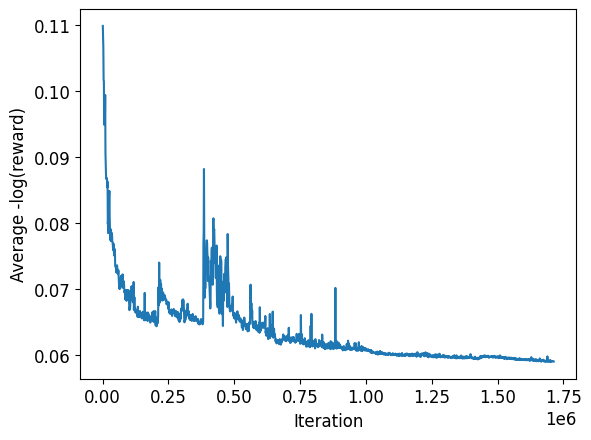

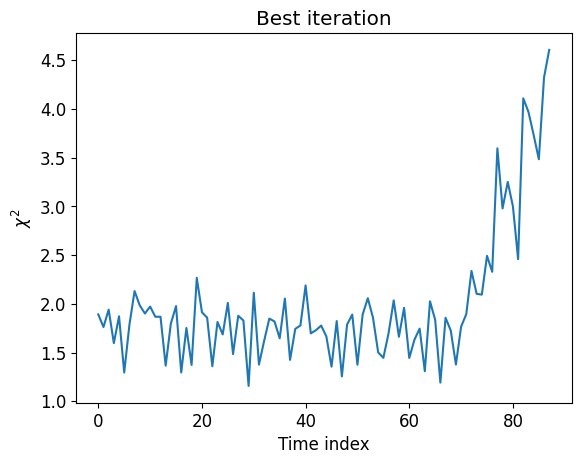

Best iteration: 1704000
  rl_model-backward_1704000_steps.zip
  reward=-2.0376544462769335
Last reward: -2.0468623641792445


In [282]:
log_dir = "./logs-bck-3/"

_dir_list = sorted(os.listdir(log_dir))

def evaluate(model):
    episode_reward = 0
    n_times = len(env.data)
    obs, info = env.reset()

    time_chi2 = []
    
    for i in range(n_times):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)  
        episode_reward += reward
        time_chi2.append(env.chi2)

    return episode_reward, time_chi2

itr_list = []
reward_list = []
time_chi2_list = []
models = []

for file in _dir_list:
    try:
        model = SAC.load(os.path.join(log_dir, file))
        reward, time_chi2 = evaluate(model)
        iteration = int(file.replace("rl_model-backward_", "").replace("_steps.zip", ""))
        itr_list.append(iteration)
        reward_list.append(reward)
        time_chi2_list.append(time_chi2)
        models.append(model)
           
    except:
        print("skip: %s" % file)

time_chi2_list = np.asarray(time_chi2_list)
itr_list = np.asarray(itr_list)
reward_list = np.asarray(reward_list)
idx = itr_list.argsort()


fig = plt.figure(dpi=100)
plt.plot(itr_list[idx], np.log(-reward_list[idx])/len(env.data))
plt.xlabel('Iteration')
plt.ylabel('Average -log(reward)')
plt.show()

_idx_max = reward_list.argmax()

fig = plt.figure(dpi=100)
plt.plot(range(len(env.data)), time_chi2_list[_idx_max])
plt.xlabel('Time index')
plt.title('Best iteration')
plt.ylabel('$\chi^2$')
plt.show()

print("Best iteration: %s" % itr_list[_idx_max])
print(f"  {_dir_list[_idx_max]}")
print(f"  reward={reward_list[_idx_max]/len(env.data)}")

_idx_last = itr_list.argmax()
print(f"Last reward: {reward_list[_idx_last]/len(env.data)}")


In [283]:
#model = models[idx[-1]]
#model = models[idx[best_idx]]

print("Loading model %s" % _dir_list[_idx_max])
model = SAC.load(os.path.join(log_dir, _dir_list[_idx_max]))

episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

times = []
actions = []
chi2 = []
for i in range(n_times):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    times.append(timestamps[env.time_stamp])
    _time = timestamps[env.time_stamp]
    new_obs, reward, terminated, truncated, info = env.step(action)  
    chi2.append(env.chi2)
    episode_reward += reward
    print("Time %s %s: %g [%s] %g" % (_time, obs, reward, terminated, episode_reward))
    obs = new_obs


actions = np.asarray(actions)
chi2 = np.asarray(chi2)
times = np.asarray(times)


Loading model rl_model-backward_1704000_steps.zip
Number of times: 88
Time 870 [1.]: -2.66802 [False] -2.66802
Time 860 [0.9885057]: -1.76162 [False] -4.42964
Time 850 [0.9770115]: -1.94004 [False] -6.36968
Time 840 [0.9655172]: -1.59647 [False] -7.96616
Time 830 [0.954023]: -1.87159 [False] -9.83775
Time 820 [0.9425287]: -1.2947 [False] -11.1325
Time 810 [0.9310345]: -1.78231 [False] -12.9148
Time 800 [0.9195402]: -2.13048 [False] -15.0452
Time 790 [0.90804595]: -1.98339 [False] -17.0286
Time 780 [0.8965517]: -1.90018 [False] -18.9288
Time 770 [0.88505745]: -1.9717 [False] -20.9005
Time 760 [0.87356323]: -1.86678 [False] -22.7673
Time 750 [0.86206895]: -1.8674 [False] -24.6347
Time 740 [0.85057473]: -1.36559 [False] -26.0003
Time 730 [0.83908045]: -1.79701 [False] -27.7973
Time 720 [0.82758623]: -1.97666 [False] -29.774
Time 710 [0.81609195]: -1.29494 [False] -31.0689
Time 700 [0.8045977]: -1.75188 [False] -32.8208
Time 690 [0.79310346]: -1.37258 [False] -34.1934
Time 680 [0.7816092]:

In [284]:
# There's likely a way to dig into the SAC parameters and fish out the action standard deviations

deltas = env.high_array - env.low_array

samples = []

for n in range(100):
    actions = []
    obs, info = env.reset()
    for i in range(len(env.data)):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
    
    actions = np.asarray(actions)
    values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
    samples.append(values)


samples = np.asarray(samples).T
print(samples.shape)

errs = np.std(samples, axis=2)
print(errs.shape)

(9, 88, 100)
(9, 88)


['enrich thickness', 'enrich interface', 'enrich rho', 'poly thickness', 'poly interface', 'poly rho', 'surface thickness', 'surface interface', 'surface rho']


Text(0.5, 0, 'time [seconds]')

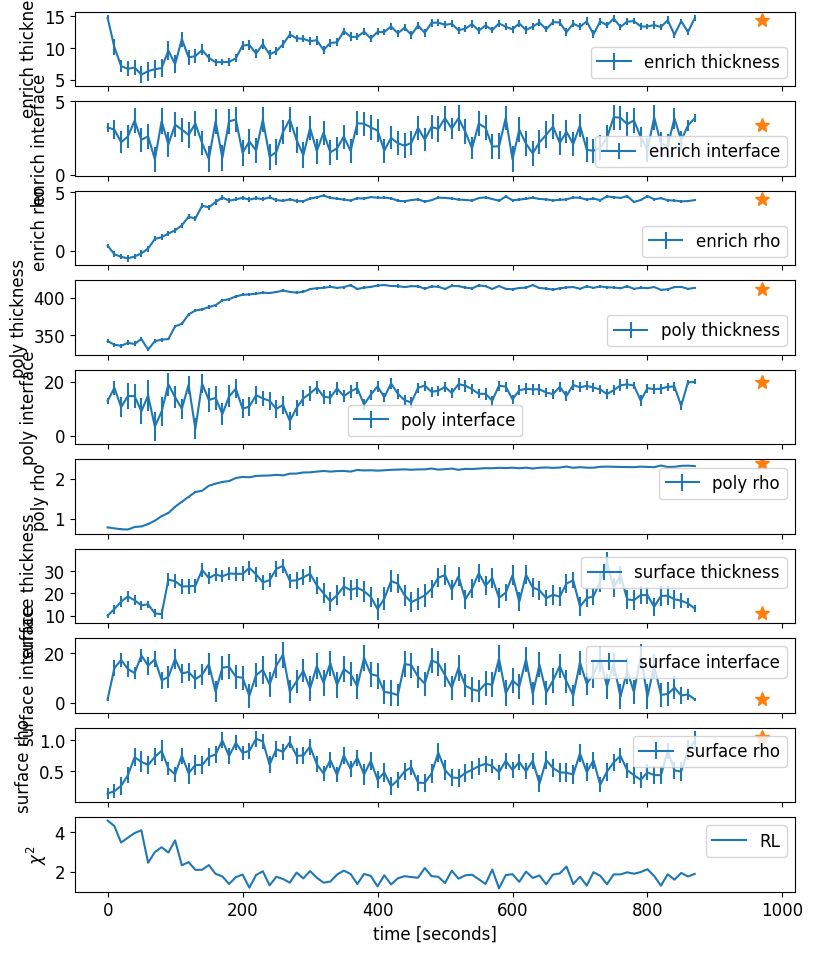

In [285]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T

# Bayesian fit trend
#with open(os.path.join(git_dir, 'data', '189245-bayes-forward.json')) as fd:
#    bayes_fits = json.load(fd)
bayes_fits = {}

t_delay = 100
if REVERSE:
    t_initial = timestamps[-1]+t_delay
    t_final = -t_delay
    _times = np.flip(timestamps)
else:
    t_final = timestamps[-1]+t_delay
    t_initial = -t_delay
    _times = timestamps

n_times = len(env.data)

n_pars = pars.shape[0]+1

fig, axs = plt.subplots(n_pars, 1, dpi=100, figsize=(9,10), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)
for i in range(pars.shape[0]):
    ax = plt.subplot(n_pars, 1, i+1)
    
    plt.errorbar(_times, pars[i], yerr=errs[i], label=env.par_labels[i])

    label = env.par_labels[i].lower().replace(" ", "_")
    if label in bayes_fits:
        values = bayes_fits[label]
        d_values = bayes_fits[label+'_err']
        plt.errorbar(_times, values, yerr=d_values, label='Bayesian fit')
    
    plt.plot([t_initial,], [env.parameters[i]], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(env.par_labels[i])
    plt.legend()

i +=1
ax = plt.subplot(n_pars, 1, i+1)
plt.plot(_times, chi2, label = 'RL')
#plt.plot(_times, bayes_fits['chi2'], label = 'Bayesian fit')
plt.legend()
plt.ylabel("$\chi^2$")
plt.xlabel("time [seconds]")

Number of times: 88


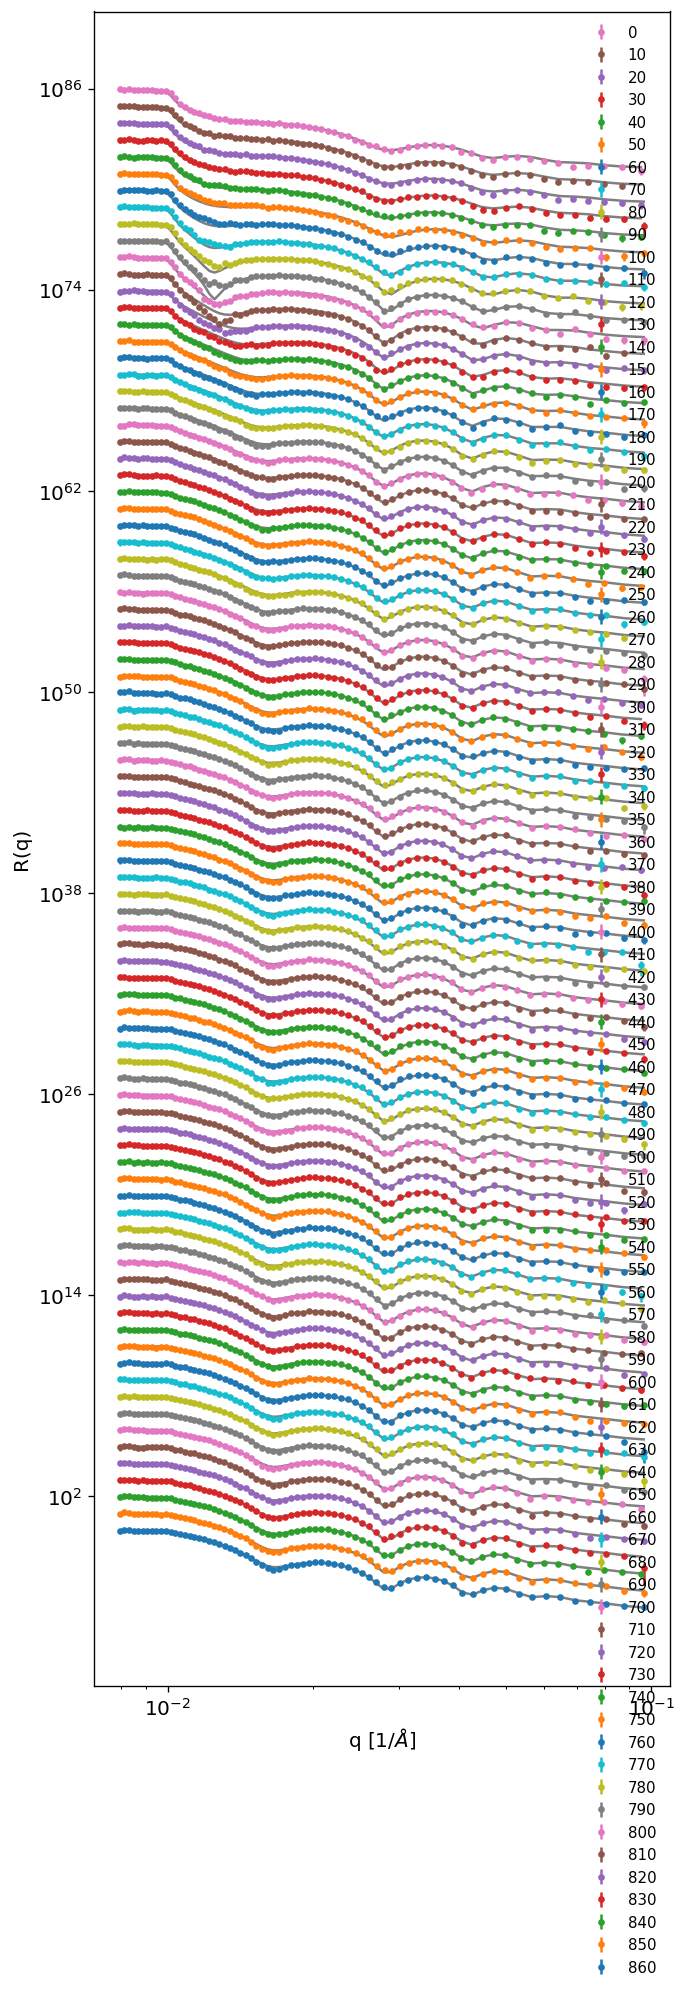

In [286]:
# Evaluate the agent
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig, ax = plt.subplots(dpi=120, figsize=(6, 15))
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.05)

offset = 0
for i in range(1, n_times, 1):
    action, _ = model.predict(obs, deterministic=True)

    obs, reward, terminated, truncated, info = env.step(action)

    if True: #i%1000 == 0:
        env.plot(scale=10**offset, newfig=False, errors=True, label=_times[i])
        offset += 1

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], frameon=False, prop={'size': 9}, loc='upper right')
#plt.xlim([0.015, 0.12])
plt.show()